In [43]:
import numpy as np
from binomial import Binomial
from calibration import calibration
from rcn import rcn
import statsmodels.formula.api as smf
from scipy.optimize import minimize
import matplotlib.pyplot as plt

Interest rate  -0.0078
Dividend yield 0.0278
------------------------------
Minimum found!
Func value     11991.8516
Up             1.0564
Down           0.9412
------------------------------


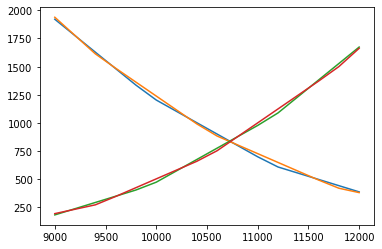

In [2]:
"""Run callibration file and return the interest rate, div yield, u and d"""
r, y, u, d = calibration()

In [3]:
#Q1)
dt = 1/12
i0 = 11118
c = 0.1

In [4]:
note  = rcn(r, dt, i0, y, u, d)
RCN = note.price_rcn(alpha=1, c=c)
BRCN = note.price_brcn(alpha=1, beta=0.8, c=c)
print('Price of simple RCN {:.4f}\nPrice of barrier RCN {:.4f}'.format(RCN, BRCN))

Price of simple RCN 1.9113
Price of barrier RCN 1.9398


In [23]:
def f(c, *arg):
    al, _ = arg
    price  = note.price_rcn(alpha=al, c=c)
    return (1 - price)**2

def g(c, *arg):
    al, bt = arg
    #print(str(eval(str(note.price_) + type)))
    price  = note.price_brcn(alpha=al, beta=beta, c=c)
    return (1 - price)**2

alpha = 1
beta= 0.8

for fun in [f, g]:
    res = minimize(fun, 0, args=(alpha, beta), method='COBYLA')
    if res.success:
        print('Minimum found!')
        c = res.x
        if fun == f:
            type = 'RCN'
        elif fun==g:
            type = 'BRCN'
        print('Par coupon rate for '+str(type)+' c={:.2%}'.format(c))

Minimum found!
Par coupon rate for RCN c=2.43%
Minimum found!
Par coupon rate for BRCN c=2.21%


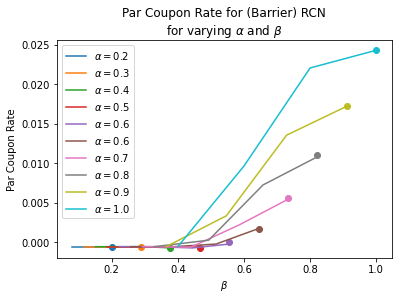

In [62]:
#Q2
alphas = np.linspace(0.2, 1, 10)
beta = np.array([0.4, 0.6,0.8, 1])
param = [(a, beta*a) for a in alphas]

c_rcn = []
c_brcn = []

for alpha, betas in param:
    for beta in betas:
        for fun in [f, g]:
            res = minimize(fun, 0, args=(alpha, beta), method='COBYLA')
            if res.success:
                c = res.x
                if fun == f:
                    #print('Minimum found! for alpha={:.1f}, beta={:.1f}'.format(alpha, beta))
                    #print('Coupon rate or RCN={:.4f}'.format(c))
                    c_rcn.append(float(c))
                elif fun==g:
                    #print('Minimum found! for alpha={:.1f}, beta={:.1f}'.format(alpha, beta))
                    #print('Coupon rate for BRCN={:.4f}'.format(c))
                    c_brcn.append(float(c))
            else: print('No minimum')


c_rcn = np.array(c_rcn)
c_brcn = np.array(c_brcn)
c_rcn = c_rcn.reshape(alphas.shape[0], 4)
c_brcn = c_brcn.reshape(alphas.shape[0], 4)

i =0
for ((alpha, betas), c) in zip(param, c_brcn):
    plt.plot(betas, c, label=r'$\alpha={:.1f}$'.format(alpha))
    plt.scatter(alpha, c_rcn[i, 0])
    plt.title('Par Coupon Rate for (Barrier) RCN\nfor varying '+r'$\alpha$ and $\beta$')
    plt.ylabel('Par Coupon Rate')
    plt.xlabel(r'$\beta$')
    #plt.plot(betas)
    plt.legend()
    i += 1

In [166]:
#Q3
c = 0.1
def f(a, *arg):
    c, _ = arg
    price  = note.price_rcn(alpha=a, c=c)
    return (1 - price)**2


const =( {'type': 'ineq', 'fun': lambda x: x - 0},
     {'type': 'ineq', 'fun': lambda x: 1 - x})

res = minimize(f, 0.5, args=(c, 0), method='SLSQP', constraints=const)
if res.success:
    print('Minimum found!')
    a = res.x
    print(a)
else:
    print('no minimum')

print(note.price_rcn(a, c))


Minimum found!
[1.]
1.9113219417397467
